# 3. Binary classification
**Goal:** The goal is to predict if the flight will be cancelled  

**Target variables:** 
- `CANCELLED` 

**Notes**:  

2% of flights are cancelled. it's a highly imbalanced dataset. We will want to predict probabilities with custom threshold.  
[Article on framework for highly imbalanced datasets](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)

**Steps**:
1. Pick evaluation metrics
2. Spot check different algos
3. Tune hyperparameters using grid search on 2-3 selected algos
4. Compare them based on the selected metrics

## Step 1. Pick evaluation metrics
**Brier score** (because we will be using probabilities in some models)  
**Precision-Recall AUC** (because positive class is more important)  
**F1 score**  

## Step 2. Spot check different algos (using K-Folds on sample data)

### Step 2.1 Spot check regular algorythms

- Naive algorythm (used as a baseline model):  
Predict the majority class 

- Linear algorythms:  
Logistic Regression  
LDA  
- Non linear algos:  
k-Nearest Neighbors  

- Ensemble algorythms:  
Random forest  
Stochastic Gradient Boosting   
XGBoost  
 *Optional: custom ensemble*

- Other
One-Class Support Vector Machines (usually used for outlier detection but can be used to do classification) - tried and took too long to train

### Step 2.2 Spot check imbalanced classification algos. Use those techniques on the ML algos to see if it improves performance

- Data sampling  
Oversampler and Undersampler method: SMOTE combined with RandomUnderSampler on the training datasets in this step [Article on how to perform SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

- Probability tuning (custom threshold) on the algos that can give probabilities as outputs  
Logistic Regression 
LDA 

- Optional: Try a [calibration algo on the predicted prbobabilities](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)



In [431]:
import numpy as np
import pandas as pd

In [441]:
# data 
data = pd.read_csv('db_binary_sample.csv', index_col = 0)
print(data.shape)
print(data.columns)

data_pca = pd.read_csv('db_binary_pca_sample.csv', index_col = 0)
print(data_pca.shape)
print(data_pca.columns)

(10000, 18)
Index(['branded_code_share', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_type', 'state_travel_type', 'm_hist_dep_delay',
       'med_hist_dep_delay', 'm_hist_arr_delay', 'med_hist_arr_delay',
       'origin_cat', 'dest_cat', 'mkt_op_combo_cat', 'cancelled'],
      dtype='object')


In [448]:
y = data.cancelled
X = data.drop('cancelled', axis = 1)
print(y.shape)
print(X.shape)

data_pca = data_pca.sample(10000) ###smaller sample
y_pca = data_pca.cancelled
X_pca = data_pca.drop('cancelled', axis = 1)
print(y.shape)
print(X.shape)

y_small = y[:1000] # used them for test only
X_small = X[:1000] # used them for test only

(10000,)
(10000, 17)


In [447]:
# get class representations
# Big sample
print(f'Class {data.cancelled.value_counts().index[0]}: {data.cancelled.value_counts().values[0]} values')
print(f'Class {data.cancelled.value_counts().index[1]}: {data.cancelled.value_counts().values[1]} values')
print(f'Sample imbalance: {data.cancelled.value_counts().values[1]/len(y)*100} %')

Class 0.0: 9834 values
Class 1.0: 166 values
Sample imbalance: 1.66 %


In [449]:
# get a smaller sample
print(f'Class {y_small.value_counts().index[0]}: {y_small.value_counts().values[0]} values')
print(f'Class {y_small.value_counts().index[1]}: {y_small.value_counts().values[1]} values')

Class 0.0: 979 values
Class 1.0: 21 values


### Step 2.1 Spot Check Algos

In [450]:
# import models to try
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# params
models = {
    'Dummy Classifier': DummyClassifier(strategy = "most_frequent"), \
    'Logistic Regression': LogisticRegression(max_iter=1000), \
    'LDA': LinearDiscriminantAnalysis(), \
#    'KNeighborsClassifier' : KNeighborsClassifier, \  #doesn,t work, gives me an error
    'Random Forest': RandomForestClassifier(), \
    'Gradient Boosting': GradientBoostingClassifier(), \
    'XGBoost': xgb.XGBClassifier(scale_pos_weight=100) \
    }

scoring = ('neg_brier_score', 'roc_auc', 'f1')

In [451]:
# this function creates two dataframe outputs: AVG scoring per model and STD scoring per model
# make sure you import the models outside of this function and that the scorings are supported by them

def perform_cross_validate(models, X, y, scoring, n_folds, plot = False):
    
    # import cross validate
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import numpy as np
    
    # create dataframe
    results_mean = pd.DataFrame(columns = list(models.keys()), index=list(scoring))
    results_std = pd.DataFrame(columns = list(models.keys()),  index=list(scoring))
    

    # perform cross validate and store desults in the dataframe
    for key in models:
        model_name = key
        model = models[key]  # this is the model's placeholder
        cv = cross_validate(estimator=model, X=X, y=y, cv=n_folds, scoring=scoring)
    
        # adds values for each scoring in the dataframes
        results_mean[model_name] = [cv['test_'+scoring[i]].mean() for i in range(len(scoring))]
        results_std[model_name] = [cv['test_'+scoring[i]].std() for i in range(len(scoring))]
        
        
    if plot:
        #setup
        to_plot = {0:311, 1:312, 2:313, 3:314, 4:315, 5:316}
        import matplotlib.pyplot as plt
        %matplotlib inline
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize'] = 12, 10
        
        # plot
        for i, score in enumerate(scoring):
            plt.subplot(to_plot[i])
            plt.bar(list(results_mean.columns),  results_mean.iloc[i].values)
            plt.title(f'Plot for: {score}')
            
    return results_mean, results_std

### 10 000 datapoints sample from db_binary_sample, 2 folds

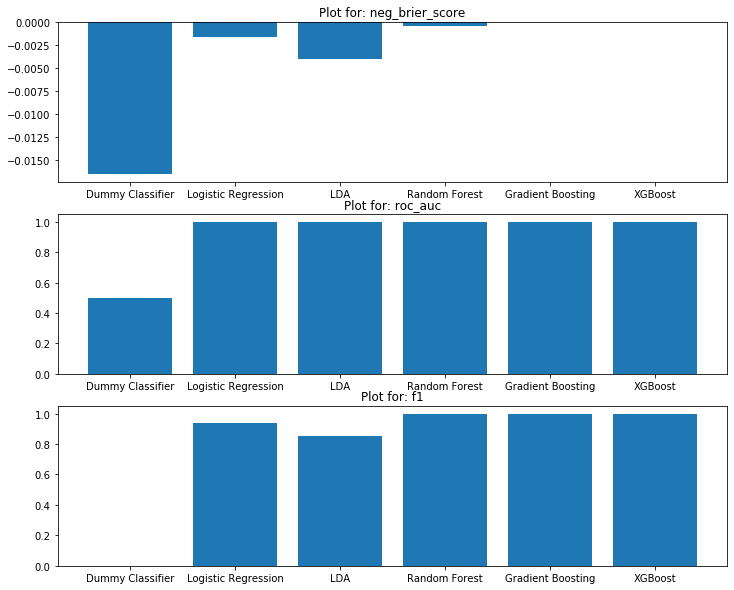

In [452]:
results_mean, results_std = perform_cross_validate(models=models, X=X, y=y, scoring=scoring, n_folds=2, plot=True)

### 10 000 datapoints sample from db_binary_sample, 3 folds

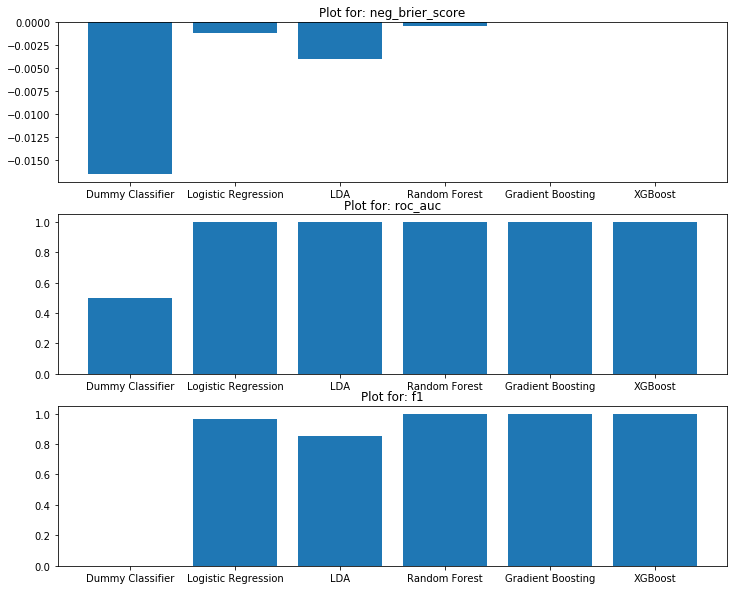

In [455]:
results_mean, results_std = perform_cross_validate(models=models, X=X, y=y, scoring=scoring, n_folds=3, plot=True)

### 10 000 datapoints sample from db_binary_pca_sample, 2 folds

In [ ]:
results_mean, results_std = perform_cross_validate(models=models, X=X_pca, y=y_pca, scoring=scoring, n_folds=3, plot=True)

## Step 3. Hyperparameter tuning
Use Grid Search to tune the selected algo (on the whole dataframe?)